In [1]:
import streamlit as st
from PIL import Image
from skimage import data
from skimage import transform
from skimage.registration import phase_cross_correlation
from skimage.feature import (blob_log)
from skimage.transform import warp_polar
from matplotlib import pyplot as plt
from skyfield.api import Star, Topos, load
from skyfield.data import hipparcos
import numpy as np
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

In [2]:

def makeDistHist(star_list):
    nblob,dem = star_list.shape
    blob_dist = []
    
    for row in range(nblob):
        rdistances = np.sqrt((star_list[:,0] - star_list[row,0])**2 + (star_list[:,1] - star_list[row,1])**2)
        rdistances /= np.max(rdistances)
        blob_dist.append(np.histogram(rdistances,bins=30)[0])
    return np.array(blob_dist)
    
stardict = {}
with open('common_stars.txt') as f:
    lines = f.readlines()
    for line in lines:
        entry = line.strip().split("\t")
        stardict[int(entry[1])] = entry[0]
        stardict[int(entry[3])] = entry[2]

df = df[df['magnitude'] <= 3.0]
print('After filtering, there are {} stars'.format(len(df)))
bright_stars = Star.from_dataframe(df)

planets = load('de421.bsp')
earth = planets['earth']
ts = load.timescale()
cos = earth + Topos('38.8605998 N', '104.6751112 W', elevation_m=2000)


def getChart(timestamp):
    t = ts.utc(timestamp.year, 
               timestamp.month, 
               timestamp.day, 
               timestamp.hour,
               timestamp.minute,
               timestamp.second)

    apparent = cos.at(t).observe(bright_stars).apparent()
    alt,az,distance = apparent.altaz()

    az_deg = np.pi*(np.array(az.degrees)) / 180

    hips = df.index
    rad = 90 - alt.degrees
    idxs = np.where(rad < 50)
    mag = np.array(10*(8-df['magnitude']))[idxs]
    x = rad[idxs]*np.cos(az_deg[idxs])/180
    y = rad[idxs]*np.sin(az_deg[idxs])/180
    #     hipvals = hips[idxs]
    ret = np.zeros((len(x),3))
    ret[:,0] = x
    ret[:,1] = y
    ret[:,2] = mag
    return ret

def adjustChart(value, rotation, xoffset, yoffset, xzoom, yzoom):
    x,y = value
    x *= xzoom
    x += xoffset
    y *= yzoom
    y += yoffset
    return x,y
    


After filtering, there are 177 stars


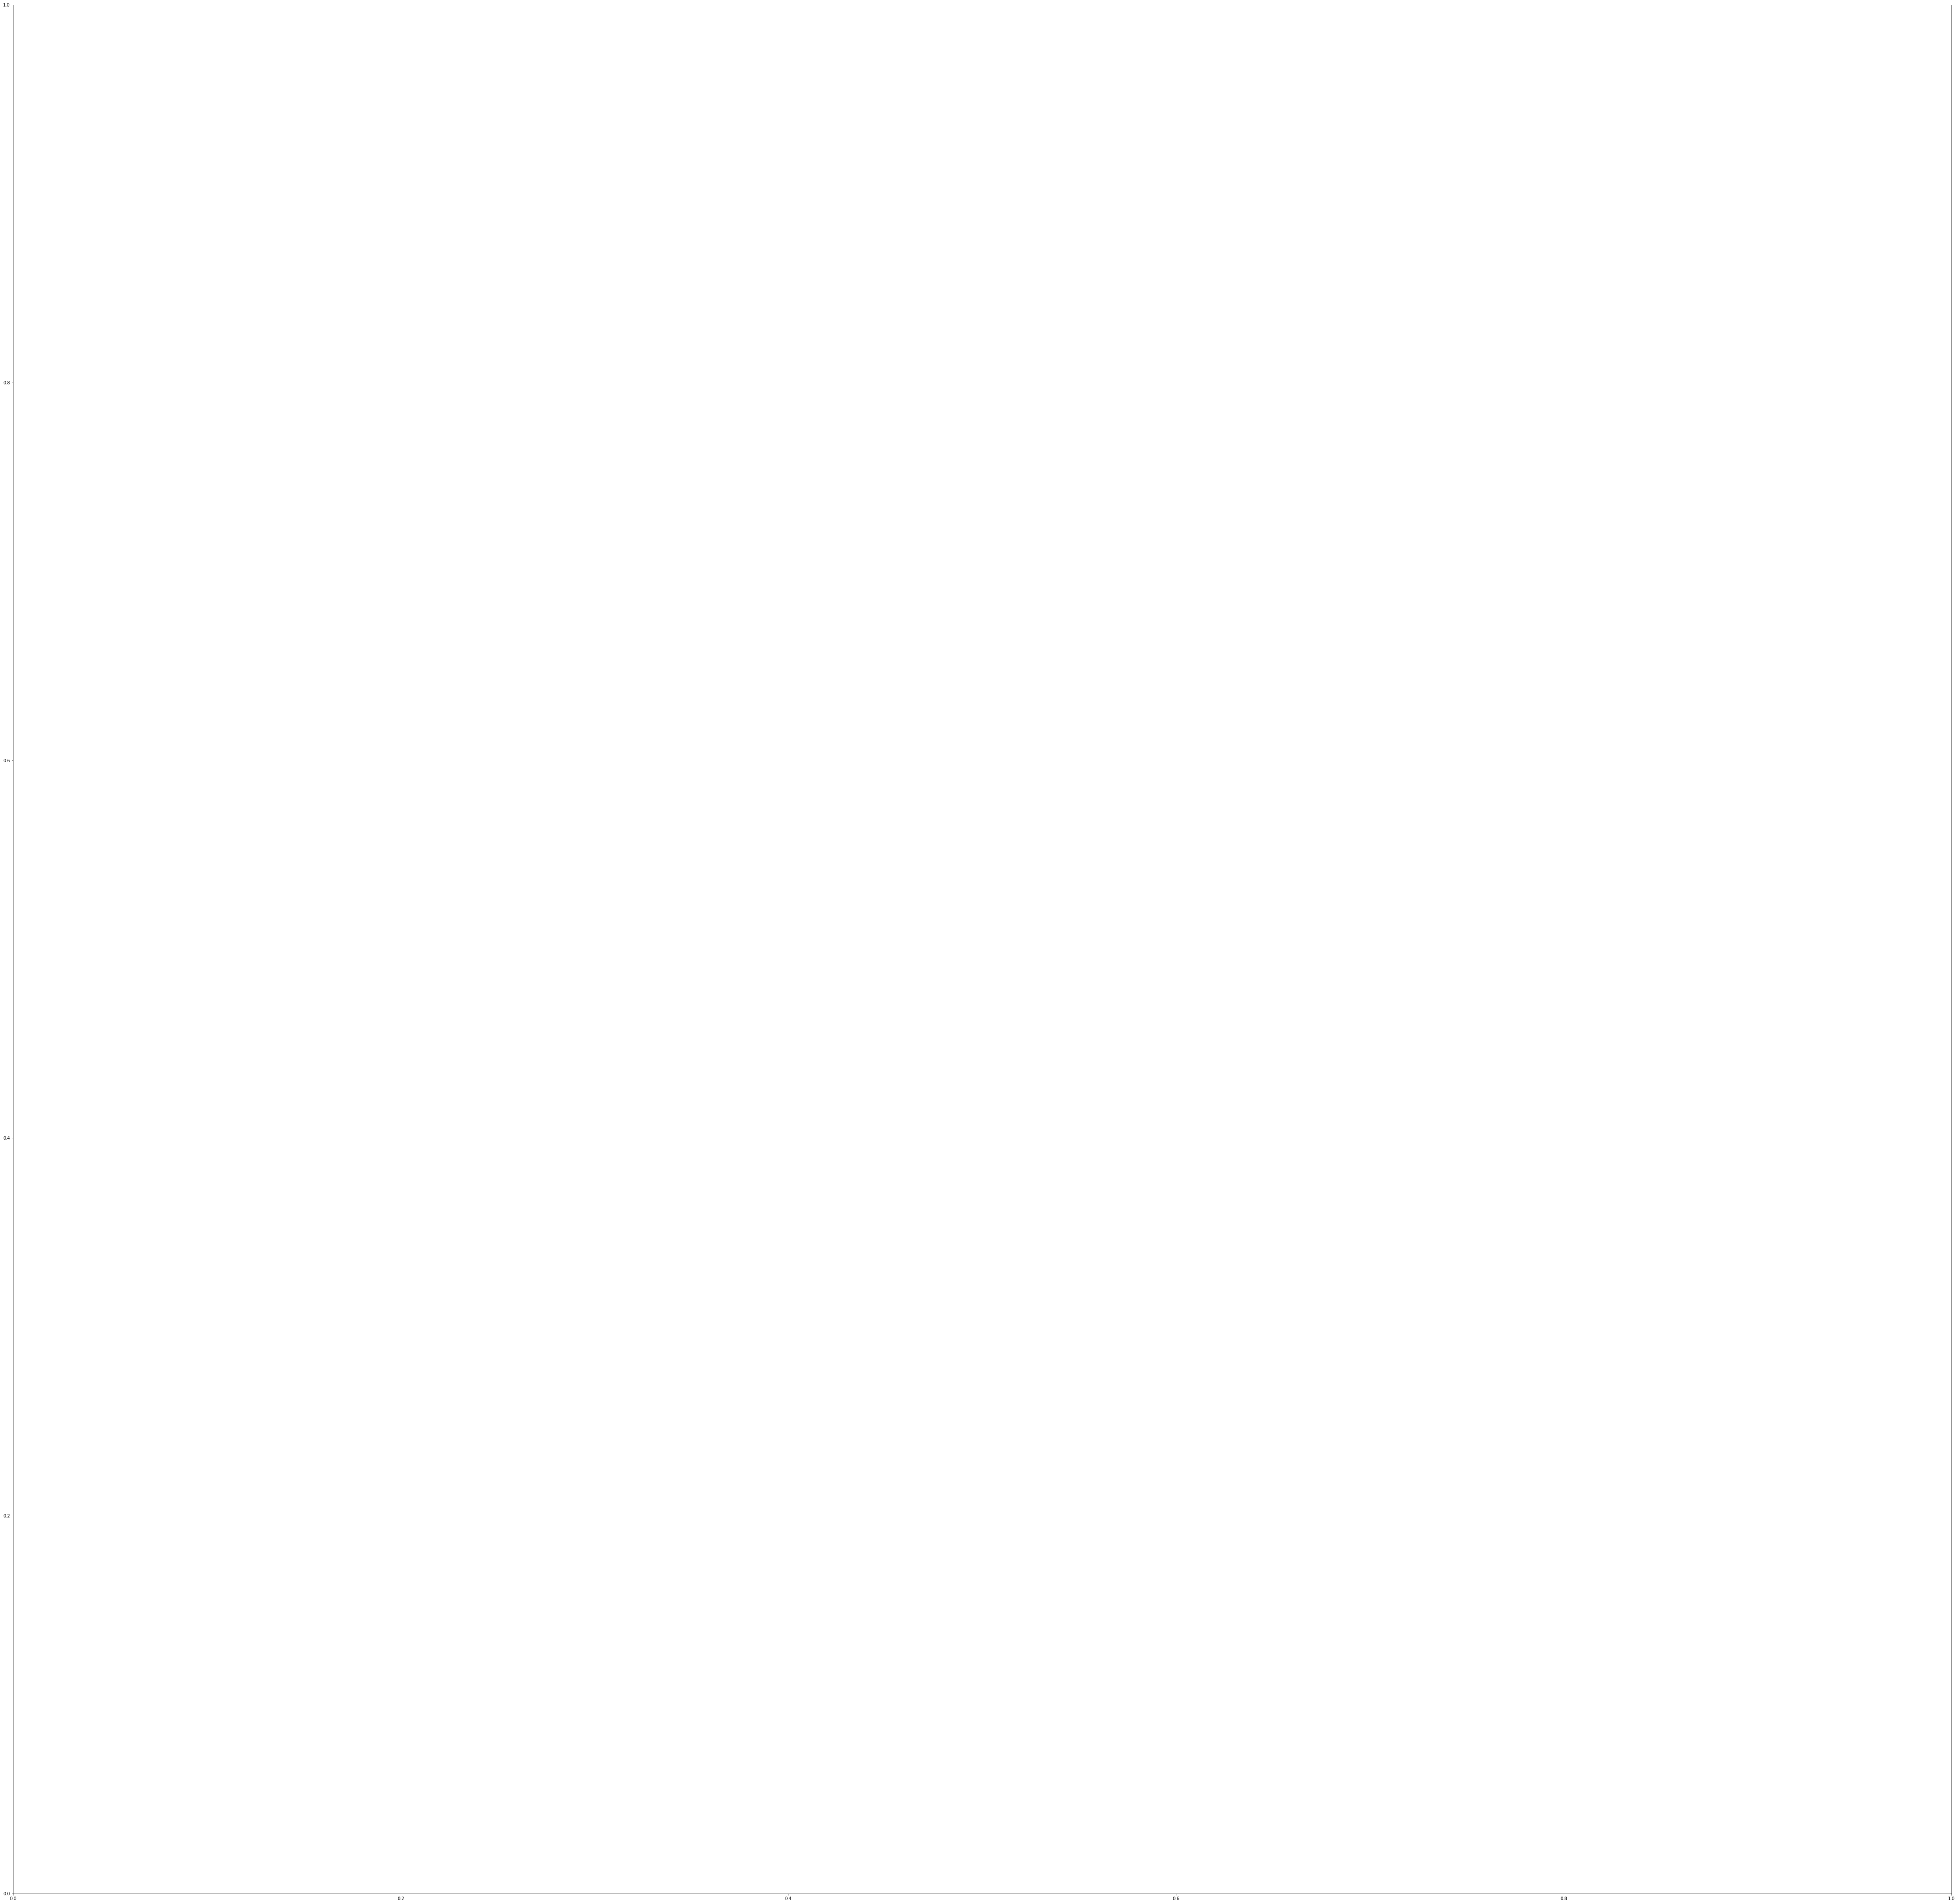

In [3]:


parray = np.zeros((1411,2072))

for cnt in range(1500):
    fname = f"streamlit/pic{cnt:06d}.dat"
#     print(fname)
    raw = np.fromfile(fname, dtype=np.float64).reshape((2822,4144))
    #     print(raw.shape)

    tstamp = os.path.getmtime(fname)
    #     print(tstamp)

    parray += 0.2125*raw[::2,::2] + 0.7154 * (raw[1::2,::2] + raw[::2,1::2]) / 2.0 + 0.0721 * raw[1::2,1::2]

565 435


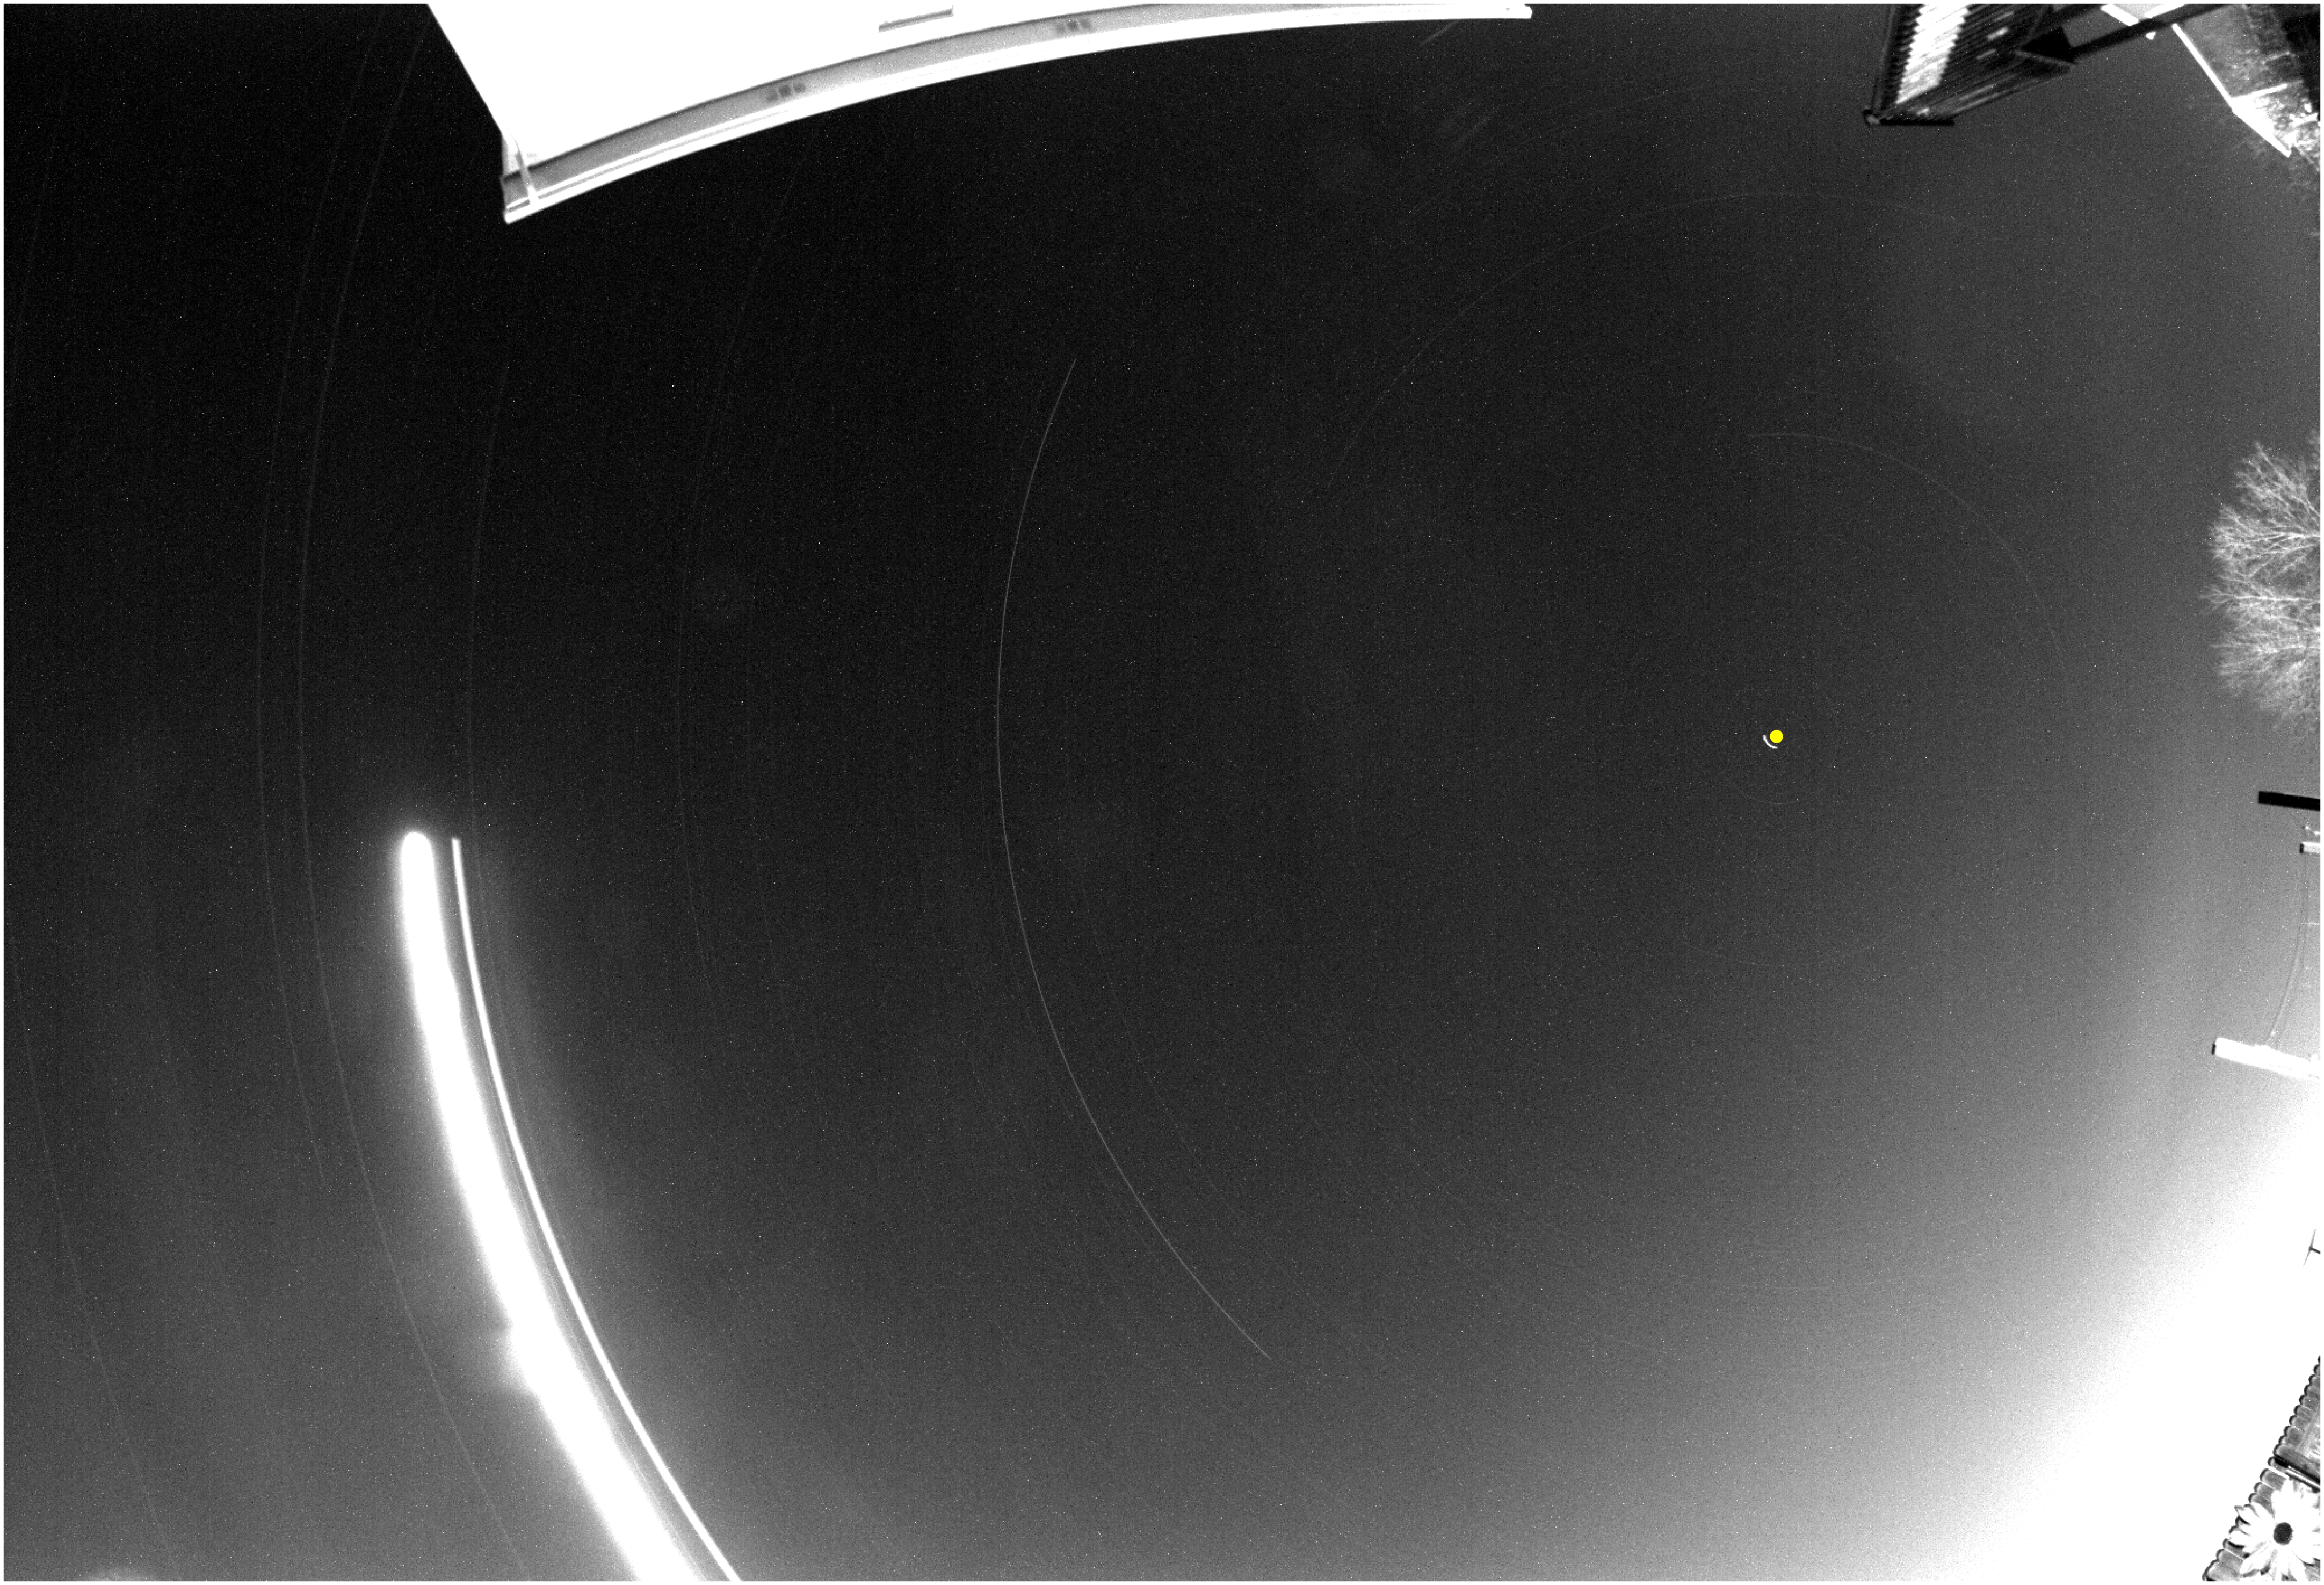

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)
out = parray / np.max(parray)
# [200:1000,1000:2000]
ax.imshow(out, cmap='gray', interpolation='none', vmin = 0.06,vmax = 0.08)
c = plt.Circle((1585, 655), 5, color='yellow', linewidth=4, fill=True)
ax.add_patch(c)
ax.set_axis_off()

mymax = np.argmax(out[200:1000,1000:2000])
print(mymax//800,1000 - mymax//800 )

plt.show()